In [1]:
from scipy.io import savemat
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import pyvista as pv
from tqdm import tqdm, trange
import time
import numexpr as ne
import fast_simplification
import numpy as np

In [266]:
def scattering_function_tetrahedron(verts, tetrahedra, q_grid):
    """
    Evaluate the scattering function of the whole mesh over a grid of wave vectors for tetrahedra.
    
    Parameters:
    vertices (numpy.ndarray): Array of shape (n, 3) containing the vertices of the mesh.
    tetrahedra (numpy.ndarray): Array of shape (m, 4) containing the indices of the vertices forming each tetrahedron.
    q_grid (list): List of 3 numpy arrays representing the grid of wave vectors.
    
    Returns:
    numpy.ndarray: The scattering function values over the grid.
    """
    print("Flattening q_grid...")
    start_time = time.time()
    q_grid_flat = np.array([q_grid[0].flatten(), q_grid[1].flatten(), q_grid[2].flatten()])
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating tetrahedron volumes...")
    start_time = time.time()
    r0 = verts[tetrahedra[:, 0]]
    r1 = verts[tetrahedra[:, 1]]
    r2 = verts[tetrahedra[:, 2]]
    r3 = verts[tetrahedra[:, 3]]
    volumes = np.abs(np.einsum('ij,ij->i', np.cross(r0 - r1, r0 - r2), r0 - r3)) / 6
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating q_dot_r for all vertices...")
    start_time = time.time()
    q_dot_r_all = verts @ q_grid_flat
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating q_dot_r for all tetrahedra...")
    start_time = time.time()
    q_dot_r_tetrahedra = q_dot_r_all[tetrahedra] # (m, 4, nq)
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating (qri - qrj), etc...")
    start_time = time.time()
    qr0 = q_dot_r_tetrahedra[:, 0, :]
    qr1 = q_dot_r_tetrahedra[:, 1, :]
    qr2 = q_dot_r_tetrahedra[:, 2, :]
    qr3 = q_dot_r_tetrahedra[:, 3, :]
    qr0_minus_qr1 = qr0 - qr1
    qr0_minus_qr2 = qr0 - qr2
    qr0_minus_qr3 = qr0 - qr3
    qr1_minus_qr2 = qr1 - qr2
    qr1_minus_qr3 = qr1 - qr3
    qr2_minus_qr3 = qr2 - qr3
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating exp_i_(qri), etc...")
    start_time = time.time()
    exp_i_qr0 = np.exp(1j * qr0)
    exp_i_qr1 = np.exp(1j * qr1)
    exp_i_qr2 = np.exp(1j * qr2)
    exp_i_qr3 = np.exp(1j * qr3)
    print(f"Time taken: {time.time() - start_time} seconds")
  
    print("Calculating Numerator...")
    Numerator0 = -exp_i_qr0*qr1_minus_qr2*qr1_minus_qr3*qr2_minus_qr3
    Numerator1 = exp_i_qr1*qr0_minus_qr2*qr0_minus_qr3*qr2_minus_qr3
    Numerator2 = exp_i_qr2*qr0_minus_qr1*qr0_minus_qr3*qr1_minus_qr3
    Numerator3 = -exp_i_qr3*qr0_minus_qr1*qr0_minus_qr2*qr1_minus_qr2
    Numerator = Numerator0 + Numerator1 + Numerator2 + Numerator3
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating Denominator...")
    Denominator01 = qr0_minus_qr1
    Denominator02 = qr0_minus_qr2
    Denominator03 = qr0_minus_qr3
    Denominator12 = qr1_minus_qr2
    Denominator13 = qr1_minus_qr3
    Denominator23 = qr2_minus_qr3
    Denominator01[Denominator01 == 0] = 1
    Denominator02[Denominator02 == 0] = 1
    Denominator03[Denominator03 == 0] = 1
    Denominator12[Denominator12 == 0] = 1
    Denominator13[Denominator13 == 0] = 1
    Denominator23[Denominator23 == 0] = 1
    Denominator = Denominator01 * Denominator02 * Denominator03 * Denominator12 * Denominator13 * Denominator23 * (1j)**3
    print(f"Time taken: {time.time() - start_time} seconds")

    
    print("Calculating F_q...")
    start_time = time.time()
    volumes_expanded = np.repeat(volumes[:, np.newaxis], q_dot_r_tetrahedra.shape[2], axis=1)
    F_q_tetrahedra = ne.evaluate("volumes_expanded * Numerator / Denominator")
    F_q = np.sum(F_q_tetrahedra, axis=0)
    print(f"Time taken: {time.time() - start_time} seconds")

    print("Calculating scattering function I_q...")
    start_time = time.time()
    I_q = np.abs(F_q) ** 2
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Scattering function calculation complete.")
    return I_q

In [267]:
# def scattering_function_tetrahedron(verts, tetrahedra, q_grid):
#     """
#     Evaluate the scattering function of the whole mesh over a grid of wave vectors for tetrahedra.
    
#     Parameters:
#     vertices (numpy.ndarray): Array of shape (n, 3) containing the vertices of the mesh.
#     tetrahedra (numpy.ndarray): Array of shape (m, 4) containing the indices of the vertices forming each tetrahedron.
#     q_grid (list): List of 3 numpy arrays representing the grid of wave vectors.
    
#     Returns:
#     numpy.ndarray: The scattering function values over the grid.
#     """
#     print("Flattening q_grid...")
#     start_time = time.time()
#     q_grid_flat = np.array([q_grid[0].flatten(), q_grid[1].flatten(), q_grid[2].flatten()])
#     print(f"Time taken: {time.time() - start_time} seconds")
    
#     print("Calculating tetrahedron volumes...")
#     start_time = time.time()
#     r0 = verts[tetrahedra[:, 0]]
#     r1 = verts[tetrahedra[:, 1]]
#     r2 = verts[tetrahedra[:, 2]]
#     r3 = verts[tetrahedra[:, 3]]
#     volumes = (np.einsum('ij,ij->i', np.cross(r0 - r1, r0 - r2), r0 - r3)) / 6
#     print(f"Time taken: {time.time() - start_time} seconds")
    
#     print("Calculating q_dot_r for all vertices...")
#     start_time = time.time()
#     q_dot_r_all = verts @ q_grid_flat
#     print(f"Time taken: {time.time() - start_time} seconds")
    
#     print("Calculating q_dot_r for all tetrahedra...")
#     start_time = time.time()
#     q_dot_r_tetrahedra = q_dot_r_all[tetrahedra] # (m, 4, nq)
#     print(f"Time taken: {time.time() - start_time} seconds")
        
#     print("Calculating exp_i_(qri), etc...")
#     start_time = time.time()
#     exp_i_qr0 = np.exp(1j * q_dot_r_tetrahedra[:, 0, :])
#     print(f"Time taken: {time.time() - start_time} seconds")
    
#     print("Calculating (qri - qrj), etc...")
#     start_time = time.time()
#     pairs = [(0, 1), (0, 2), (0, 3)]
#     Deltas = np.array([q_dot_r_tetrahedra[:, pair[1], :]-q_dot_r_tetrahedra[:, pair[0], :] for pair in pairs])
#     i_zeros = Deltas == 0
#     n_zeros = np.sum(i_zeros, axis=0)
#     print(f"Time taken: {time.time() - start_time} seconds")

#     ## Case 0: no zeros
#     index_0 = n_zeros == 0
#     Deltas_0 = Deltas[:, index_0]
#     if np.sum(index_0) > 0:
#         print("case 0")
#         term_s = Deltas_0[0] # 1-0
#         term_t = Deltas_0[1] # 2-0
#         term_r = Deltas_0[2] # 3-0
#         term_exp_s = np.exp(1j * term_s)
#         term_exp_t = np.exp(1j * term_t)
#         term_exp_r = np.exp(1j * term_r)

#         J_0 = exp_i_qr0[index_0]*(1j / (term_r * (term_r - term_t) * term_t)) * (
#             (term_exp_t * term_r) / (term_s - term_t) +
#             (term_exp_r * term_t) / (term_r - term_s) +
#             (term_exp_s * term_r * (term_r - term_t) * term_t) / (term_s * (term_s - term_t) * (term_r - term_s)) +
#             (-term_r + term_t) / term_s
#         )
        
#         # Case when term_s == term_t
#         equal_terms = np.isclose(term_s, term_t)
#         J_0[equal_terms] = (exp_i_qr0[index_0] * (
#             (-1j * term_s ** 2 * (-1 + np.exp(1j * term_r) - 1j * term_r) + 
#              1j * (-1 + np.exp(1j * term_s)) * term_r ** 2 + 
#              term_s * term_r ** 2) / 
#             (term_s ** 2 * (term_s - term_r) * term_r ** 2)
#         ))[equal_terms]
        
#         # Case when term_s == term_r
#         equal_terms = np.isclose(term_s, term_r)
#         J_0[equal_terms] = (exp_i_qr0[index_0] * (
#             (-1j * term_s ** 2 * (-1 + np.exp(1j * term_t) - 1j * term_t) + 
#              1j * (-1 + np.exp(1j * term_s)) * term_t ** 2 + 
#              term_s * term_t ** 2) / 
#             (term_s ** 2 * (term_s - term_t) * term_t ** 2)
#         ))[equal_terms]
        
#         # Case when term_r == term_t
#         equal_terms = np.isclose(term_t, term_r)
#         J_0[equal_terms] = (exp_i_qr0[index_0] * (
#             (-1j * term_s ** 2 * (-1 + np.exp(1j * term_t) - 1j * term_t) + 
#              1j * (-1 + np.exp(1j * term_s)) * term_t ** 2 + 
#              term_s * term_t ** 2) / 
#             (term_s ** 2 * (term_s - term_t) * term_t ** 2)
#             ))[equal_terms]
#     else:
#         J_0 = np.array([])
        
#     ## Case 1: one zero
#     index_1 = n_zeros == 1
#     Deltas_1 = Deltas[:, index_1]
#     if np.sum(index_1) > 0:
#         print("case 1")
#         term_s = np.zeros(Deltas_1.shape[1], dtype=complex)
#         term_t = np.zeros(Deltas_1.shape[1], dtype=complex)

#         for i in range(Deltas_1.shape[1]):
#             non_zero_terms = Deltas_1[:, i][Deltas_1[:, i] != 0]
#             term_s[i] = non_zero_terms[0]
#             term_t[i] = non_zero_terms[1]

#         J_1 = exp_i_qr0[index_1] * (
#             (-1j * term_s ** 2 * (-1 + np.exp(1j * term_t) - 1j * term_t) + 
#              1j * (-1 + np.exp(1j * term_s)) * term_t ** 2 + 
#              term_s * term_t ** 2) / 
#             (term_s ** 2 * (term_s - term_t) * term_t ** 2)
#         )
        
#         # Case when term_s == term_t
#         equal_terms = np.isclose(term_s, term_t)
#         J_1[equal_terms] = (exp_i_qr0[index_1] *(1j / 2) * (-2 + 2 * np.exp(1j * term_s) + term_s * (-2j + term_s)) / (term_s ** 3))[equal_terms]
#     else:
#         J_1 = np.array([])
    
#     ## Case 2: two zeros
#     index_2 = n_zeros == 2
#     Deltas_2 = Deltas[:, index_2]
#     if np.sum(index_2) > 0:
#         print("case 2")
#         term_s = Deltas_2[0]
        
#         J_2 = (exp_i_qr0[index_2] *(1j / 2) * (-2 + 2 * np.exp(1j * term_s) + term_s * (-2j + term_s)) / (term_s ** 3))
#     else:
#         J_2 = np.array([])
    
#     ## Case 3: three zeros
#     index_3 = n_zeros == 3
#     if np.sum(index_3) > 0:
#         print("case 3")
#         J_3 = exp_i_qr0[index_3] / 6
#     else:
#         J_3 = np.array([])
    
#     # Combine J_0, J_1, J_2, and J_3
#     J = np.zeros(n_zeros.shape, dtype=complex)
#     if J_0.size > 0:
#         J[index_0] = J_0
#     if J_1.size > 0:
#         J[index_1] = J_1
#     if J_2.size > 0:
#         J[index_2] = J_2
#     if J_3.size > 0:
#         J[index_3] = J_3

#     volumes_expanded = np.repeat(volumes[:, np.newaxis], q_dot_r_tetrahedra.shape[2], axis=1)
#     F_q_tetrahedra = ne.evaluate("volumes_expanded * J")
#     F_q = np.sum(F_q_tetrahedra, axis=0)
#     print(f"Time taken: {time.time() - start_time} seconds")

#     print("Calculating scattering function I_q...")
#     start_time = time.time()
#     I_q = np.abs(F_q) ** 2
#     print(f"Time taken: {time.time() - start_time} seconds")
    
#     return I_q, i_zeros


## Generate regular polynedron pillar

In [268]:
# We consider particles having the shape of a right prism of length L and a cross-section made of a regular polygon with n sides
def generate_prism(n, R, AR, center = (0, 0, 0)):
    """
    Generate vertices and faces for a right prism with a regular polygon base.
    
    Parameters:
    n (int): Number of sides of the regular polygon.
    R (float): Radius of circumradius circle of the regular polygon.
    AR (float): Aspect ratio of the prism.
    
    Returns:
    tuple: Tuple containing vertices and faces of the prism.
    """
    # Calculate the area of the base polygon
    r = R/2/np.pi 
    A = 0.5 * n * r**2 * np.sin(2*np.pi/n)
    
    # Calculate the R_ave of the base polygon
    R_ave = np.sqrt(A/np.pi)
    
    # Calculate the length of the prism
    L = AR * R_ave*2
    
    
    # Generate the vertices of the base polygon
    theta = np.linspace(0, 2 * np.pi, n, endpoint=False) + 1e-6
    x = np.cos(theta)*r
    y = np.sin(theta)*r
    z = np.zeros_like(x)
    print(r)
    
    # Vertices of the top and bottom faces
    vertices = np.vstack((np.column_stack((x, y, z)), np.column_stack((x, y, z + L))))
    
    # # Generate the faces
    # faces = []
    # for i in range(n):
    #     next_i = (i + 1) % n
    #     # Bottom face
    #     faces.append([i, next_i, next_i + n, i + n])
    #     # Top face
    #     faces.append([i, next_i, next_i + n, i + n])
    
    return vertices

23.8732414637843


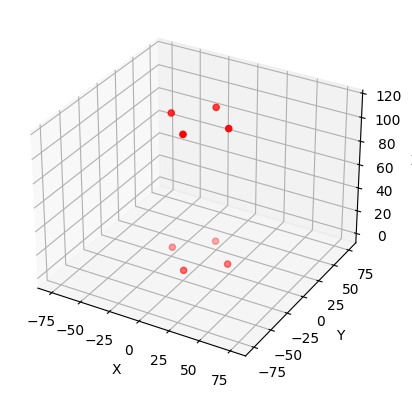

In [269]:
# Generate the vertices and faces of the prism
n = 4
R = 150
AR = 3
vertices = generate_prism(n, R, AR)
L = np.max(vertices[:, 2]) - np.min(vertices[:, 2])
# v_bottom = np.array([0, 0, 0])
# v_top = np.array([0, 0, L])
# vertices = np.vstack((vertices, v_top, v_bottom))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, z coordinates of vertices
x = vertices[:, 0]
y = vertices[:, 1]
z = vertices[:, 2]

# Plot the vertices
ax.scatter(x, y, z, c='r', marker='o')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_aspect('equal')

plt.show()

23.8732414637843
0, 1
1, 2
2, 3
3, 0


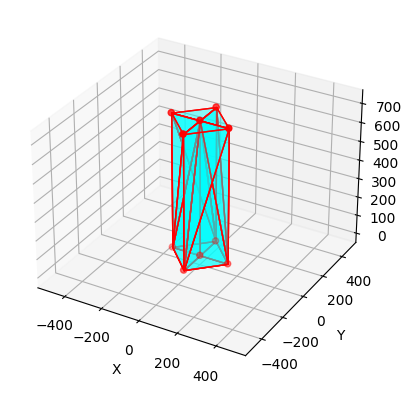

In [270]:
verts = generate_prism(n, R, AR)
L = np.max(vertices[:, 2]) - np.min(vertices[:, 2])
v_bottom = np.array([0, 0, 0])
v_top = np.array([0, 0, L])
verts = np.vstack((verts, v_bottom, v_top))*2*np.pi

# Rotate verts around z-axis
# theta_z = np.pi/4
# rotation_matrix_z = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
#                               [np.sin(theta_z), np.cos(theta_z), 0],
#                               [0, 0, 1]])
# verts = verts @ rotation_matrix_z.T

# stretch_matrix = np.array([[2,0,0],[0,1,0],[0,0,1]])
# verts = verts @ stretch_matrix.T

# Rotate verts around x-axis
theta_x = 1e-5
rotation_matrix_x = np.array([[1, 0, 0],
                              [0, np.cos(theta_x), -np.sin(theta_x)],
                              [0, np.sin(theta_x), np.cos(theta_x)]])
verts = verts @ rotation_matrix_x.T

# Rotate verts around y-axis
theta_y = 2e-5
rotation_matrix_y = np.array([[np.cos(theta_y), 0, np.sin(theta_y)],
                              [0, 1, 0],
                              [-np.sin(theta_y), 0, np.cos(theta_y)]])
verts = verts @ rotation_matrix_y.T


# generate the vertices of the tertrahedra
tetrahedra = []
for i in range(n):
    next_i = (i + 1) % n
    print(f"{i}, {next_i}")
    tri_prism = [2*n, i, next_i, 2*n+1, i+n, next_i+n]
    # tri_prism = [0,1,2,3,4,5]
    tetrahedra.append([tri_prism[0], tri_prism[1], tri_prism[2], tri_prism[3]])
    tetrahedra.append([tri_prism[1], tri_prism[3], tri_prism[4], tri_prism[5]])
    tetrahedra.append([tri_prism[1], tri_prism[2], tri_prism[3], tri_prism[5]])
    
tetrahedra = np.array(tetrahedra)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, tetra in enumerate(tetrahedra):
    color = 'cyan'
    for face in [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]:
        verts_face = verts[tetra[face]]
        ax.add_collection3d(Poly3DCollection([verts_face], facecolors=color, linewidths=1, edgecolors='r', alpha=.25))

# Extract x, y, z coordinates of vertices
x = verts[:, 0]
y = verts[:, 1]
z = verts[:, 2]

# Plot the vertices
ax.scatter(x, y, z, c='r', marker='o')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_aspect('equal')

plt.show()

In [274]:
qx = np.linspace(-1, 1, 100)*0.1
qy = np.linspace(-1, 1, 100)*0.1
qz = 0

q_grid = np.meshgrid(qx, qy, qz)
# q_grid_flat = np.array([q_grid[0].flatten(), q_grid[1].flatten(), q_grid[2].flatten()])
I_q_grid_flat = scattering_function_tetrahedron(verts, tetrahedra, q_grid)
I_q = I_q_grid_flat.reshape(q_grid[0].shape)

Flattening q_grid...
Time taken: 0.00020456314086914062 seconds
Calculating tetrahedron volumes...
Time taken: 0.00010132789611816406 seconds
Calculating q_dot_r for all vertices...
Time taken: 3.409385681152344e-05 seconds
Calculating q_dot_r for all tetrahedra...
Time taken: 0.00014925003051757812 seconds
Calculating (qri - qrj), etc...
Time taken: 0.0003287792205810547 seconds
Calculating exp_i_(qri), etc...
Time taken: 0.008249282836914062 seconds
Calculating Numerator...
Time taken: 0.010895013809204102 seconds
Calculating Denominator...
Time taken: 0.011341094970703125 seconds
Calculating F_q...
Time taken: 0.0006725788116455078 seconds
Calculating scattering function I_q...
Time taken: 2.5033950805664062e-05 seconds
Scattering function calculation complete.


In [275]:
np.sum(i_zeros, axis=0)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

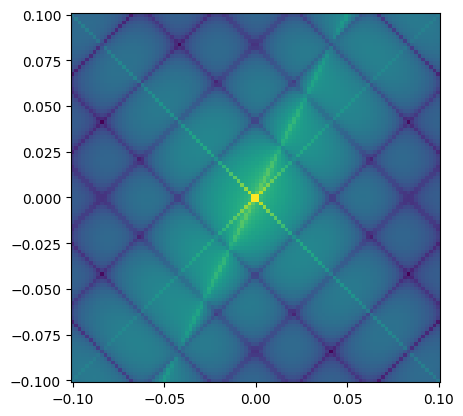

In [276]:
fig = plt.figure()
ax = fig.add_subplot(111)

# pcolor plot of the scattering function
qx_plot = q_grid[0][:,:, 0]
qy_plot = q_grid[1][:,:, 0]
I_q_plot = I_q[:,:, 0]
ax.pcolor(qx_plot, qy_plot, np.log(I_q_plot), cmap='viridis')

ax.set_aspect('equal')

## for different polygons

In [277]:
def generate_tetrahedra(n, R, AR):
    verts = generate_prism(n, R, AR)
    L = np.max(verts[:, 2]) - np.min(verts[:, 2])
    v_bottom = np.array([0, 0, 0])
    v_top = np.array([0, 0, L])
    verts = np.vstack((verts, v_bottom, v_top)) * 2 * np.pi

    # generate the vertices of the tetrahedra
    tetrahedra = []
    for i in range(n):
        next_i = (i + 1) % n
        tri_prism = [2 * n, i, next_i, 2 * n + 1, i + n, next_i + n]
        tetrahedra.append([tri_prism[0], tri_prism[1], tri_prism[2], tri_prism[3]])
        tetrahedra.append([tri_prism[1], tri_prism[3], tri_prism[4], tri_prism[5]])
        tetrahedra.append([tri_prism[1], tri_prism[2], tri_prism[3], tri_prism[5]])

    tetrahedra = np.array(tetrahedra)
    return verts, tetrahedra

23.8732414637843
23.8732414637843
Flattening q_grid...
Time taken: 0.0003600120544433594 seconds
Calculating tetrahedron volumes...
Time taken: 8.559226989746094e-05 seconds
Calculating q_dot_r for all vertices...
Time taken: 0.012797832489013672 seconds
Calculating q_dot_r for all tetrahedra...
Time taken: 0.008524656295776367 seconds
Calculating (qri - qrj), etc...
Time taken: 0.007954120635986328 seconds
Calculating exp_i_(qri), etc...
Time taken: 0.1542987823486328 seconds
Calculating Numerator...
Time taken: 0.21280789375305176 seconds
Calculating Denominator...
Time taken: 0.2258303165435791 seconds
Calculating F_q...
Time taken: 0.006140470504760742 seconds
Calculating scattering function I_q...
Time taken: 0.00019550323486328125 seconds
Scattering function calculation complete.
23.8732414637843
Flattening q_grid...
Time taken: 0.0004839897155761719 seconds
Calculating tetrahedron volumes...
Time taken: 8.988380432128906e-05 seconds
Calculating q_dot_r for all vertices...
Time t

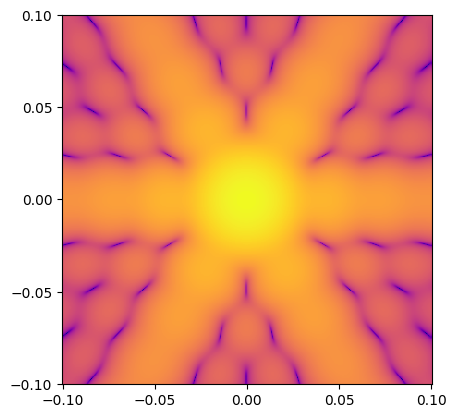

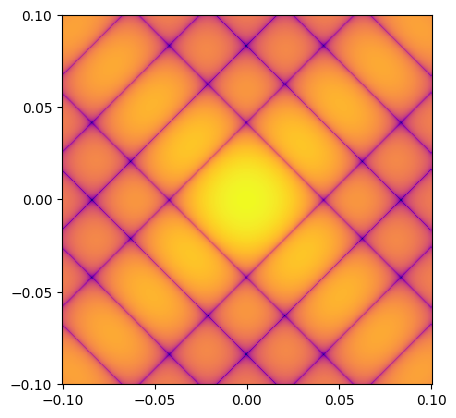

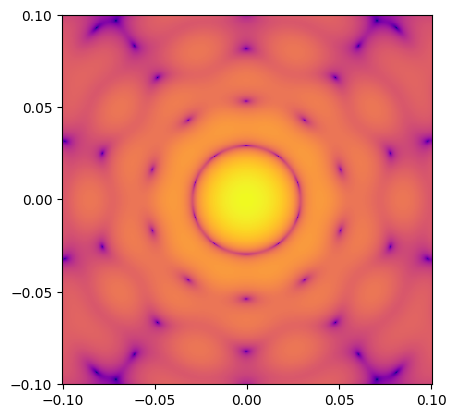

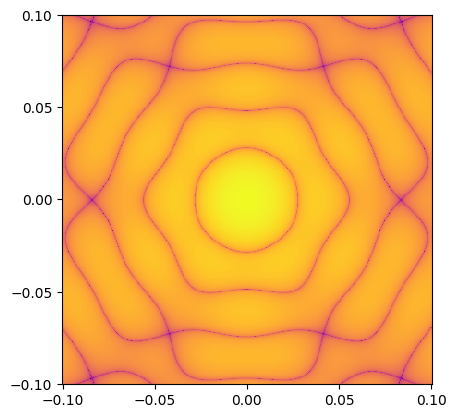

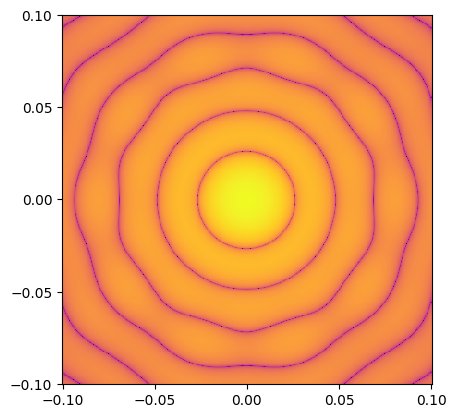

In [278]:
qx = np.linspace(-1, 1, 400)*0.1
qy = np.linspace(-1, 1, 400)*0.1
qz = 0

q_grid = np.meshgrid(qx, qy, qz)

n_list = [3, 4, 5, 6, 10]
verts, tetrahedra = generate_tetrahedra(4, 150, 3)
for n in n_list:
    verts, tetrahedra = generate_tetrahedra(n, R, AR)
    I_q_grid_flat = scattering_function_tetrahedron(verts, tetrahedra, q_grid)
    I_q = I_q_grid_flat.reshape(q_grid[0].shape)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # pcolor plot of the scattering function
    qx_plot = q_grid[0][:,:, 0]
    qy_plot = q_grid[1][:,:, 0]
    I_q_plot = I_q[:,:, 0]
    ax.pcolor(qx_plot, qy_plot, np.log(I_q_plot), cmap='plasma')
    ax.set_xticks(np.linspace(-0.1, 0.1, 5))
    ax.set_yticks(np.linspace(-0.1, 0.1, 5))
    ax.set_aspect('equal')

## test concave shapes

150
3
23.8732414637843
62.50095757382058
0, 1
1, 2
2, 3
3, 4
4, 0


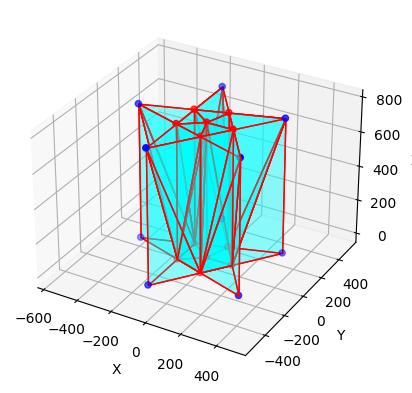

In [279]:
## Center polygon
n = 5
R = 150
AR = 3

print(R)
print(AR)
vertices_poly = generate_prism(n, R, AR)
L = np.max(vertices_poly[:, 2]) - np.min(vertices_poly[:, 2])
v_bottom = np.array([0, 0, 0])
v_top = np.array([0, 0, L])
vertices_poly = np.vstack((vertices_poly, v_bottom, v_top))*2*np.pi

tips_extend = np.tan(2*np.pi/n)*np.sin(np.pi/n) + np.cos(np.pi/n)
vertices_tips = generate_prism(n, R*tips_extend, AR/tips_extend)
# Rotate verts around z-axis
theta_z = np.pi/n
rotation_matrix_z = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
                              [np.sin(theta_z), np.cos(theta_z), 0],
                              [0, 0, 1]])
vertices_tips = vertices_tips @ rotation_matrix_z.T

vertices_tips = vertices_tips*2*np.pi

verts = np.vstack((vertices_poly, vertices_tips))

tetrahedra = []
for i in range(n):
    next_i = (i + 1) % n
    print(f"{i}, {next_i}")
    tri_prism = [2*n, i, next_i, 2*n+1, i+n, next_i+n]
    # tri_prism = [0,1,2,3,4,5]
    tetrahedra.append([tri_prism[0], tri_prism[1], tri_prism[2], tri_prism[3]])
    tetrahedra.append([tri_prism[1], tri_prism[3], tri_prism[4], tri_prism[5]])
    tetrahedra.append([tri_prism[1], tri_prism[2], tri_prism[3], tri_prism[5]])
    
    tri_prism_tips = [2*n+i+2, i, next_i, 3*n+i+2, i+n, next_i+n]
    tetrahedra.append([tri_prism_tips[0], tri_prism_tips[1], tri_prism_tips[3], tri_prism_tips[2]])
    tetrahedra.append([tri_prism_tips[1], tri_prism_tips[3], tri_prism_tips[5], tri_prism_tips[4]])
    tetrahedra.append([tri_prism_tips[1], tri_prism_tips[2], tri_prism_tips[5], tri_prism_tips[3]])
    
tetrahedra = np.array(tetrahedra)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, z coordinates of vertices
x = vertices_poly[:, 0]
y = vertices_poly[:, 1]
z = vertices_poly[:, 2]
# Plot the vertices
ax.scatter(x, y, z, c='r', marker='o',zorder=100)

# Extract x, y, z coordinates of vertices
xt = vertices_tips[:, 0]
yt = vertices_tips[:, 1]
zt = vertices_tips[:, 2]
# Plot the vertices
ax.scatter(xt, yt, zt, c='b', marker='o',zorder=100)

# plot the tetrahedra
for i, tetra in enumerate(tetrahedra):
    color = 'cyan'
    for face in [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]:
        verts_face = verts[tetra[face]]
        ax.add_collection3d(Poly3DCollection([verts_face], facecolors=color, linewidths=1, edgecolors='r', alpha=.25))

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_aspect('equal')

plt.show()

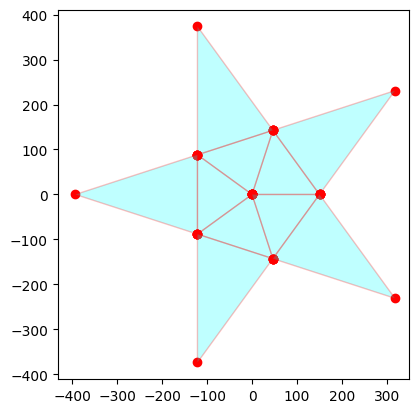

In [280]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(n):
    tetra_inner = tetrahedra[i*6]
    verts_inner = verts[tetra_inner]
    ax.scatter(verts_inner[:, 0], verts_inner[:, 1], c='r', marker='o')
    triangle = plt.Polygon(verts_inner[[0, 1, 2], :2], facecolor='cyan', edgecolor='r', alpha=0.25)
    ax.add_patch(triangle)
    
    tetra_outer = tetrahedra[i*6+3+1]
    verts_outer = verts[tetra_outer]
    ax.scatter(verts_outer[:, 0], verts_outer[:, 1], c='r', marker='o')
    triangle = plt.Polygon(verts_outer[[0, 1, 2], :2], facecolor='cyan', edgecolor='r', alpha=0.25)
    ax.add_patch(triangle)

ax.set_xlim(np.min(verts[:, 0])*1.1, np.max(verts[:, 0])*1.1)
ax.set_ylim(np.min(verts[:, 1])*1.1, np.max(verts[:, 1])*1.1)
ax.set_aspect('equal')

plt.show()

In [281]:
qx = np.linspace(-1, 1, 500)*0.1
qy = np.linspace(-1, 1, 500)*0.1
qz = 0

q_grid = np.meshgrid(qx, qy, qz)
# q_grid_flat = np.array([q_grid[0].flatten(), q_grid[1].flatten(), q_grid[2].flatten()])
I_q_grid_flat = scattering_function_tetrahedron(verts, tetrahedra, q_grid)
I_q = I_q_grid_flat.reshape(q_grid[0].shape)

Flattening q_grid...
Time taken: 0.0005035400390625 seconds
Calculating tetrahedron volumes...
Time taken: 0.00010061264038085938 seconds
Calculating q_dot_r for all vertices...
Time taken: 0.013058900833129883 seconds
Calculating q_dot_r for all tetrahedra...
Time taken: 0.04300642013549805 seconds
Calculating (qri - qrj), etc...
Time taken: 0.10640382766723633 seconds
Calculating exp_i_(qri), etc...
Time taken: 0.9101922512054443 seconds
Calculating Numerator...
Time taken: 1.2365703582763672 seconds
Calculating Denominator...
Time taken: 1.318570613861084 seconds
Calculating F_q...
Time taken: 0.037062883377075195 seconds
Calculating scattering function I_q...
Time taken: 0.0003101825714111328 seconds
Scattering function calculation complete.


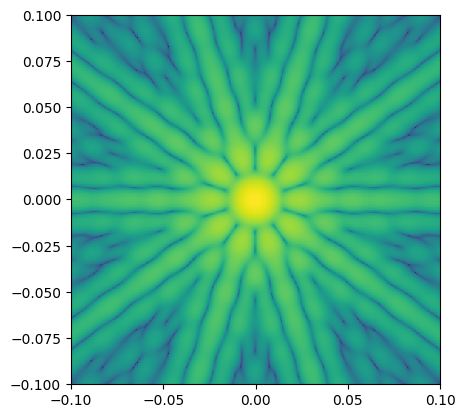

In [282]:
fig = plt.figure()
ax = fig.add_subplot(111)

# pcolor plot of the scattering function
qx_plot = q_grid[0][:,:, 0]
qy_plot = q_grid[1][:,:, 0]
I_q_plot = I_q[:,:, 0]
ax.pcolor(qx_plot, qy_plot, np.log(I_q_plot), cmap='viridis')

ax.set_aspect('equal')

Processing for n = 6
23.8732414637843
41.34966715663439


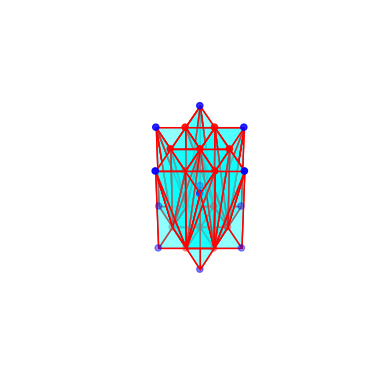

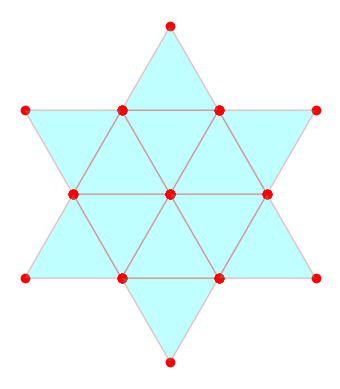

Flattening q_grid...
Time taken: 0.001409292221069336 seconds
Calculating tetrahedron volumes...
Time taken: 8.177757263183594e-05 seconds
Calculating q_dot_r for all vertices...
Time taken: 0.009011507034301758 seconds
Calculating q_dot_r for all tetrahedra...
Time taken: 0.1295914649963379 seconds
Calculating (qri - qrj), etc...
Time taken: 0.09920620918273926 seconds
Calculating exp_i_(qri), etc...
Time taken: 0.7881033420562744 seconds
Calculating Numerator...
Time taken: 1.1647884845733643 seconds
Calculating Denominator...
Time taken: 1.2624824047088623 seconds
Calculating F_q...
Time taken: 0.04176688194274902 seconds
Calculating scattering function I_q...
Time taken: 0.00030684471130371094 seconds
Scattering function calculation complete.


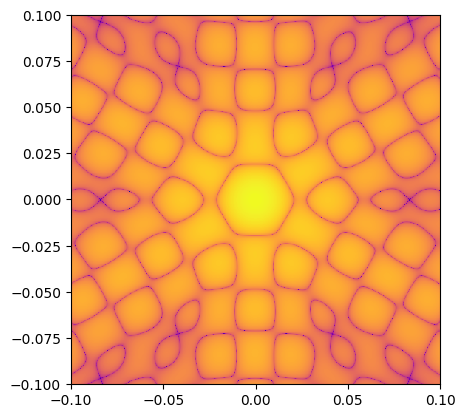

In [283]:
n_list = [6]
R = 150
AR = 3

for n in n_list:
    print(f"Processing for n = {n}")
    vertices_poly = generate_prism(n, R, AR)
    L = np.max(vertices_poly[:, 2]) - np.min(vertices_poly[:, 2])
    v_bottom = np.array([0, 0, 0])
    v_top = np.array([0, 0, L])
    vertices_poly = np.vstack((vertices_poly, v_bottom, v_top)) * 2 * np.pi

    tips_extend = np.tan(2 * np.pi / n) * np.sin(np.pi / n) + np.cos(np.pi / n)
    vertices_tips = generate_prism(n, R * tips_extend, AR / tips_extend)
    # Rotate verts around z-axis
    theta_z = np.pi / n
    rotation_matrix_z = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
                                  [np.sin(theta_z), np.cos(theta_z), 0],
                                  [0, 0, 1]])
    vertices_tips = vertices_tips @ rotation_matrix_z.T

    vertices_tips = vertices_tips * 2 * np.pi

    verts = np.vstack((vertices_poly, vertices_tips))

    tetrahedra = []
    for i in range(n):
        next_i = (i + 1) % n
        tri_prism = [2 * n, i, next_i, 2 * n + 1, i + n, next_i + n]
        tetrahedra.append([tri_prism[0], tri_prism[1], tri_prism[2], tri_prism[3]])
        tetrahedra.append([tri_prism[1], tri_prism[3], tri_prism[4], tri_prism[5]])
        tetrahedra.append([tri_prism[1], tri_prism[2], tri_prism[3], tri_prism[5]])

        tri_prism_tips = [2 * n + i + 2, i, next_i, 3 * n + i + 2, i + n, next_i + n]
        tetrahedra.append([tri_prism_tips[0], tri_prism_tips[1], tri_prism_tips[3], tri_prism_tips[2]])
        tetrahedra.append([tri_prism_tips[1], tri_prism_tips[3], tri_prism_tips[5], tri_prism_tips[4]])
        tetrahedra.append([tri_prism_tips[1], tri_prism_tips[2], tri_prism_tips[5], tri_prism_tips[3]])

    tetrahedra = np.array(tetrahedra)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract x, y, z coordinates of vertices
    x = vertices_poly[:, 0]
    y = vertices_poly[:, 1]
    z = vertices_poly[:, 2]
    # Plot the vertices
    ax.scatter(x, y, z, c='r', marker='o', zorder=100)

    # Extract x, y, z coordinates of vertices
    xt = vertices_tips[:, 0]
    yt = vertices_tips[:, 1]
    zt = vertices_tips[:, 2]
    # Plot the vertices
    ax.scatter(xt, yt, zt, c='b', marker='o', zorder=100)

    # plot the tetrahedra
    for i, tetra in enumerate(tetrahedra):
        color = 'cyan'
        for face in [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]:
            verts_face = verts[tetra[face]]
            ax.add_collection3d(Poly3DCollection([verts_face], facecolors=color, linewidths=1, edgecolors='r', alpha=.25))

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_aspect('equal')
    ax.view_init(elev=60., azim=30)
    ax.axis('off')

    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111)

    for i in range(n):
        tetra_inner = tetrahedra[i * 6]
        verts_inner = verts[tetra_inner]
        ax.scatter(verts_inner[:, 0], verts_inner[:, 1], c='r', marker='o')
        triangle = plt.Polygon(verts_inner[[0, 1, 2], :2], facecolor='cyan', edgecolor='r', alpha=0.25)
        ax.add_patch(triangle)

        tetra_outer = tetrahedra[i * 6 + 3 + 1]
        verts_outer = verts[tetra_outer]
        ax.scatter(verts_outer[:, 0], verts_outer[:, 1], c='r', marker='o')
        triangle = plt.Polygon(verts_outer[[0, 1, 2], :2], facecolor='cyan', edgecolor='r', alpha=0.25)
        ax.add_patch(triangle)

    ax.set_xlim(np.min(verts[:, 0]) * 1.1, np.max(verts[:, 0]) * 1.1)
    ax.set_ylim(np.min(verts[:, 1]) * 1.1, np.max(verts[:, 1]) * 1.1)
    ax.set_aspect('equal')
    ax.axis('off')

    plt.show()

    qx = np.linspace(-1, 1, 500) * 0.1
    qy = np.linspace(-1, 1, 500) * 0.1
    qz = 0

    q_grid = np.meshgrid(qx, qy, qz)
    I_q_grid_flat = scattering_function_tetrahedron(verts, tetrahedra, q_grid)
    I_q = I_q_grid_flat.reshape(q_grid[0].shape)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # pcolor plot of the scattering function
    qx_plot = q_grid[0][:, :, 0]
    qy_plot = q_grid[1][:, :, 0]
    I_q_plot = I_q[:, :, 0]
    ax.pcolor(qx_plot, qy_plot, np.log(I_q_plot), cmap='plasma')

    ax.set_aspect('equal')
    plt.show()
